<a href="https://www.kaggle.com/code/aleksandrmorozov123/quant-finance-in-python?scriptVersionId=195335243" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Brownian motion for financial math**

In [2]:
import math
import itertools
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

**A Brownian motion is a stochastic process $\{W_t\}_{t \in [0,T]}$. \\\
Filtered probability space $(\Omega, \mathcal{F}, \mathbb{P}, \{\mathcal{F}_t\}_{t\in [0, T]})$** \\\
$W:[0, T] \times \Omega \rightarrow \mathbb{R}$
1. $W_0 = 0$
2. $W$ has independent increments
3. $W$ has Gaussian (normal) increments
4. $W$ has continuous sample paths (almost surely)

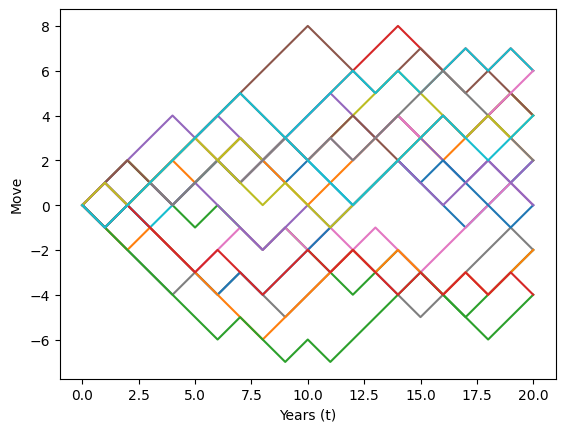

In [3]:
# parameters 
M = 20  # number of simulations
t = 20 # time

random_walk = [-1, 1]
steps = np.random.choice (random_walk, size = (M, t)).T
origin = np.zeros ((1, M))
rw_paths = np.concatenate ([origin, steps]).cumsum (axis = 0)

plt.plot (rw_paths)
plt.xlabel ("Years (t)")
plt.ylabel ("Move")
plt.show ()


**Create quadratic variation and variance functions**

In [4]:
quadratic_variation = lambda x: round (np.square (x[:-1] - x[1:]).sum(), 3)
variance = lambda x: round (np.var (x, axis = 0), 3)
[quadratic_variation (path) for path in rw_paths.T [:4]]

[20.0, 20.0, 20.0, 20.0]

In [5]:
# change the number of simulation to 10 000 000 to observe variance convergence on Time
[variance (path) for path in rw_paths [1:11]]

[0.99, 1.39, 2.16, 4.59, 6.91, 9.15, 9.55, 11.6, 12.04, 10.75]

**Scaled symmetric random walk** \\\
To approximate a Brownian motion we can speed up time and scale down the step size
$$ W^{(n)} (t) = \frac{1}{\sqrt{n}} M_{nt} $$

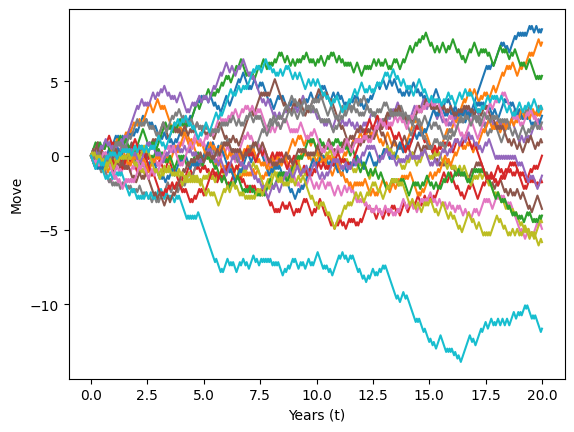

In [6]:
# paremeters 
M = 20 # number of simulations
t = 20 # Time
n = 20

random_walk = [-1, 1]
steps = (1/np.sqrt (n)) * np.random.choice (random_walk, size = (M, t * n)).T
origin = np.zeros ((1, M))
srw_paths = np.concatenate ([origin, steps]).cumsum (axis = 0)

time = np.linspace (0, t, t * n + 1)
tt = np.full (shape = (M, t * n + 1), fill_value = time)
tt = tt.T

plt.plot (tt, srw_paths)
plt.xlabel ("Years (t)")
plt.ylabel ("Move")
plt.show ()

**Change the number of simulation to 100 000 to observe variance convergence on Time**

In [7]:
[variance (path) for path in srw_paths [1:11]]

[0.046, 0.102, 0.166, 0.212, 0.192, 0.225, 0.205, 0.238, 0.218, 0.21]

**Geometric Brownian motion** \\\
GBm is defined in the following Stochastic Differential Equation
$$ dS_t = \mu S_t dt + \sigma S_t d W_t $$

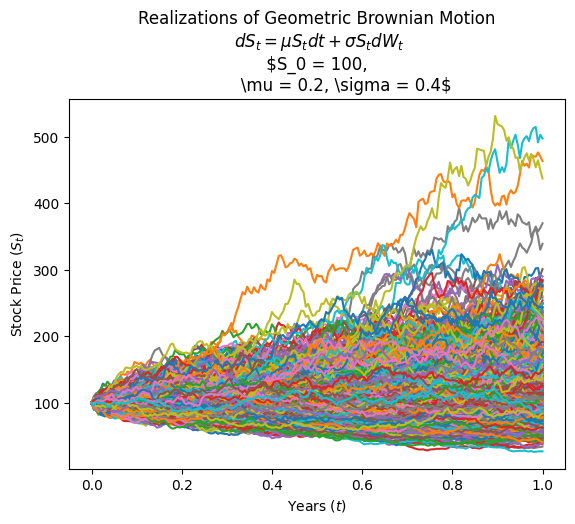

In [8]:
# Parameters
mu = 0.2  # drift coefficien
n = 200 # number of steps
T = 1 # time in years
M = 1000 # number of simulations
S0 = 100 # inital stock price
sigma = 0.4 # volatility

# calc each time step 
dt = T/n

# simulation using numpy arrays
St = np.exp ((mu - sigma ** 2 / 2) * dt
            + sigma * np.random.normal (0, np.sqrt (dt), size = (M, n)).T)

# include array of 1's
St = np.vstack ([np.ones (M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis = 0)
St = S0 * St.cumprod (axis = 0)

# define time interval correctly 
time = np.linspace (0, T, n + 1)

# require numpy array that is the same shape as St
tt = np.full (shape = (M, n + 1), fill_value = time).T

# plotting results
plt.plot (tt, St)
plt.xlabel ("Years $(t)$")
plt.ylabel ("Stock Price $(S_t)$")
plt.title ("""Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, 
           \mu = {1}, \sigma = {2}$""".format(S0, mu, sigma)
)
plt.show ()

**Monte Carlo variance reduction methods - antithetic**

In [9]:
# initial derivative parameters
S = 101.33  # stock price'
K = 97.57   # strike price
vol = 0.1486  # volatility (%)
r = 0.18  # risk-free rate
N = 20   # number of time steps
M = 1000   # number of simulations

market_value = 4.76   # market price of option
T = ((datetime.date (2024, 2, 20) - datetime.date (2024, 2, 10)).days + 1) / 365  # time in years
print (T)

0.030136986301369864


**Slow solution - we break it down inot slow discretized steps, although for the purposes of a European Call Option we do not have to take steps as the discretization perfectly represents the SDE**

In [10]:
# precompute constants
dt = T/N
nudt = (r - 0.5 * vol ** 2) * dt
volsdt = vol * np.sqrt (dt)
lnS = np.log (S)

# standard error placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range (M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range (N):
        # perfectly negatively correlated assets
        epsilon = np.random.normal ()
        lnSt1 = lnSt1 + nudt + volsdt * epsilon
        lnSt2 = lnSt2 + nudt - volsdt * epsilon
        
    ST1 = np.exp (lnSt1)
    ST2 = np.exp (lnSt2)
    CT = 0.5 * (max (0, ST1 - K) + max (0, ST2 - K))
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT * CT
    
# compute expectation and SE
C0 = np.exp (-r * T) * sum_CT / M
sigma = np.sqrt (( sum_CT2 - sum_CT * sum_CT/M ) * np.exp (-2 * r * T) /(M - 1))
SE = sigma / np.sqrt (M)

print ("Call value is ${0} with SE +/- {1}".format (np.round (C0, 2), np.round (SE, 2)))

Call value is $4.33 with SE +/- 0.01


**Fast solution - vectorized**

In [11]:
# precompute constants
N = 1
dt = T/N
nudt = (r - 0.5 * vol ** 2) * dt
volsdt = vol * np.sqrt (dt)
lnS = np.log (S)

# Monte Carlo method
Z = np.random.normal (size = (N, M))
delta_lnSt1 = nudt + volsdt * Z
delta_lnSt2 = nudt + volsdt * Z
lnSt1 = lnS + np.cumsum (delta_lnSt1, axis = 0)
lnSt2 = lnS + np.cumsum (delta_lnSt2, axis = 0)

# compute expectation and SE
ST1 = np.exp (lnSt1)
ST2 = np.exp (lnSt2)
CT = 0.5 * (np.maximum (0, ST1[-1] - K) + np.maximum (0, ST2 [-1] - K))
C0 = np.exp (-r * T) * np.sum (CT) / M

sigma = np.sqrt (np.sum ((CT - C0) ** 2) / (M - 1))
SE = sigma / np.sqrt (M)

print ("Call value is ${0} with SE +/- {1}".format (np.round (C0, 2), np.round (SE, 2)))

Call value is $4.43 with SE +/- 0.08


**Compare without Antithetic Variate**

In [12]:
# precompute constants
N = 1
dt = T/N
nudt = (r - 0.5 * vol ** 2) * dt
volsdt = vol * np.sqrt (dt)
lnS = np.log (S)

# Monte Carlo method
Z = np.random.normal (size = (N, M))
delta_lnSt = nudt + volsdt * Z
lnSt = lnS + np.cumsum (delta_lnSt, axis = 0)
lnSt = np.concatenate ((np.full (shape = (1, M), fill_value = lnS), lnSt))

# compute expectation and SE
ST = np.exp (lnSt)
CT = np.maximum (0, ST - K)
C0w = np.exp (-r * T) * np.sum (CT[-1])/ M

sigma = np.sqrt (np.sum ((CT[-1] - C0) ** 2) / (M - 1))
SEw = sigma / np.sqrt (M)

print ("Call value is ${0} with SE +/- {1}".format (np.round (C0, 2), np.round (SE, 2)))

Call value is $4.43 with SE +/- 0.08


**Visualisation of convergence**

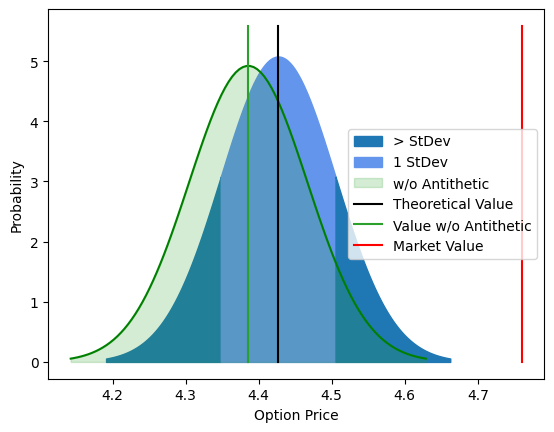

In [13]:
x1 = np.linspace (C0 - 3 * SE, C0 - 1 * SE, 100)
x2 = np.linspace (C0 - 1 * SE, C0 + 1 * SE, 100)
x3 = np.linspace (C0 + 1 * SE, C0 + 3 * SE, 100)
xw = np.linspace (C0w - 3 * SEw, C0w + 3 * SEw, 100)

s1 = stats.norm.pdf (x1, C0, SE)
s2 = stats.norm.pdf (x2, C0, SE)
s3 = stats.norm.pdf (x3, C0, SE)
sw = stats.norm.pdf (xw, C0w, SEw)

plt.fill_between (x1, s1, color = 'tab:blue', label ='> StDev')
plt.fill_between (x2, s2, color = 'cornflowerblue', label = '1 StDev')
plt.fill_between (x3, s3, color = 'tab:blue')
plt.plot (xw, sw, 'g-')
plt.fill_between (xw, sw, alpha = 0.2, color = 'tab:green', label = 'w/o Antithetic')

plt.plot ([C0, C0], [0, max (s2) * 1.1], 'k', label = 'Theoretical Value')
plt.plot ([C0w, C0w], [0, max (s2) * 1.1], color = 'tab:green', label = 'Value w/o Antithetic')
plt.plot ([market_value, market_value], [0, max (s2) * 1.1], 'r', label = 'Market Value')

plt.ylabel ("Probability")
plt.xlabel ("Option Price")
plt.legend ()
plt.show ()